# mixed model

pickle the model files and load here to test

In [135]:
import torch
import importlib
from collections import Counter
from sklearn.metrics import confusion_matrix
import score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import nltk
import numpy as np
import preprocessing
from collections import Counter
from sklearn.preprocessing import StandardScaler
import json
import itertools

In [20]:
preprocess = preprocessing.Preprocessing()

In [14]:
#load training idf json
idf = {}
with open('idf_training.json',"r") as idf_file:
    idf = json.load(idf_file)

In [17]:
#load test data
test_labels = pd.read_csv("fn_data/competition_test_stances.csv")
test_labels = list(test_labels['Stance'])
test_stances = pd.read_csv("fn_data/competition_test_stances_unlabeled.csv")
print(test_stances.shape)
test_stances.head()

(25413, 2)


,Headline,Body ID
0,Ferguson riots: Pregnant woman loses eye after...,2008
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550
2,A Russian Guy Says His Justin Bieber Ringtone ...,2
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793
4,Argentina's President Adopts Boy to End Werewo...,37


In [10]:
test_bodies = pd.read_csv("fn_data/competition_test_bodies.csv")
print(test_bodies.shape)
test_bodies.head()

(904, 2)


,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...


In [21]:
#preprocess test data
body_info = preprocess.process_bodies(test_bodies, idf)

processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
done! processed 904


In [22]:
feats_list = [
    'shared_nouns',
    'shared_verbs',
    'shared_bigrams',
    'shared_tokens',

    'shared_nouns_fst',
    'shared_verbs_fst',
    'shared_bigrams_fst',
    'shared_tokens_fst',

    'shared_nouns_sig',
    'shared_verbs_sig',
    'shared_bigrams_sig',
    'shared_tokens_sig',

    'svo_s_fst',
    'svo_v_fst',
    'svo_o_fst',
    
    'svo_s_sig',
    'svo_v_sig',
    'svo_o_sig',
    
    'cos_nouns_sig',
    'cos_bigrams_sig',
    'cos_tokens_sig',

    'cos_nouns_fst',
    'cos_bigrams_fst',
    'cos_tokens_fst']

In [23]:
#extract features test data
import time
start = time.time()
data_feats = [preprocess.get_feats(i, body_info) for i in test_stances.values]
end = time.time()
print(int(end-start))

315


In [24]:
test_df = pd.DataFrame()
for i in feats_list:
    test_df[i] = [x[i] for x in data_feats]

In [28]:
scaler = StandardScaler()
for i in feats_list:
    test_df[i] = scaler.fit_transform(test_df[i].values.reshape(-1,1))
test_df.head()

,shared_nouns,shared_verbs,shared_bigrams,shared_tokens,shared_nouns_fst,shared_verbs_fst,shared_bigrams_fst,shared_tokens_fst,shared_nouns_sig,shared_verbs_sig,...,svo_o_fst,svo_s_sig,svo_v_sig,svo_o_sig,cos_nouns_sig,cos_bigrams_sig,cos_tokens_sig,cos_nouns_fst,cos_bigrams_fst,cos_tokens_fst
0,-0.482403,-0.244399,0.0,-0.503674,-0.497574,-0.262627,-0.343451,-0.541887,-0.421358,-0.172937,...,-0.182139,-0.262908,-0.113817,-0.15656,-0.415593,-0.16204,-0.479903,-0.361586,-0.168145,-0.559429
1,-0.482403,-0.244399,0.0,-0.503674,-0.497574,-0.262627,-0.343451,-0.541887,-0.421358,-0.172937,...,-0.182139,-0.262908,-0.113817,-0.15656,-0.415593,-0.16204,-0.479903,-0.361586,-0.168145,-0.559429
2,-0.482403,-0.244399,0.0,-0.503674,-0.497574,-0.262627,-0.343451,-0.541887,-0.421358,-0.172937,...,-0.182139,-0.262908,-0.113817,-0.15656,-0.415593,-0.16204,-0.479903,-0.361586,-0.168145,-0.559429
3,-0.482403,-0.244399,0.0,-0.503674,-0.497574,-0.262627,-0.343451,-0.541887,-0.421358,-0.172937,...,-0.182139,-0.262908,-0.113817,-0.15656,-0.415593,-0.16204,-0.479903,-5.308922,-0.168145,-0.559429
4,-0.482403,-0.244399,0.0,-0.503674,-0.497574,-0.262627,-0.343451,-0.541887,-0.421358,-0.172937,...,-0.182139,-0.262908,-0.113817,-0.15656,-0.415593,-0.16204,-0.479903,-0.361586,-0.168145,-0.559429


In [40]:
from joblib import dump, load
rf_model = load('rf_trained.joblib')

In [29]:
glove_dict = preprocess.get_glove_dict("glove.6B.50d")

In [115]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs,embedding_dim)) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes)*n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x): 
        #x (batch size, 60, 91)
        embedded = x.unsqueeze(1) 
        #embedded (batch size, 1, 60, 91)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs] 
        #conv_n = [batch size, n_filters, 60 - filter_sizes[n]]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved] 
        #pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat(pooled, dim=1)) 
        #cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat), F.log_softmax(self.fc(cat), dim=1)

In [31]:
def process_text_stance(text, glove_dict, n_words = 20):
    def process_word_stance(word):
        #50d word vector
        if word in glove_dict:
            wv = glove_dict[word]
        else:
            wv = np.random.normal(scale=0.6, size=(50, ))
        #4d sentiment
        sent = preprocess.get_sentiment(word)
        #36d one-hot encoding of part of speech
        pos = nltk.pos_tag(word)[1]
        pos_encoding = [(1 if tag == pos else 0) for tag in preprocess.pos_tags]
        #boolean flag for negating word
        is_neg = (1 if word in preprocess.negating_words_lemmatized else 0)
        wv = np.concatenate([wv, [sent["pos"], sent["neg"], sent["neu"], sent["compound"], is_neg], pos_encoding])
        return wv
    tokens = preprocess.get_clean_tokens(text, False)
    if len(tokens)>=n_words:
        tokens = tokens[:n_words]
        text_encoding = np.array([process_word_stance(token) for token in tokens])
    elif len(tokens)<n_words:
        padding = [np.zeros((91,))]*(n_words-len(tokens))
        text_encoding = [process_word_stance(token) for token in tokens]+padding
        text_encoding = np.array(text_encoding)
    return text_encoding

def process_bodies_stance(df, glove_dict):
    body_inf = {}
    ids = list(df["Body ID"])
    for i in range(len(ids)):
        if i % 100 == 0 and i != 0:
            print("processed "+str(i))
        body_inf[ids[i]] = process_text_stance(preprocess.get_body(ids[i],df), glove_dict, 40)
    print("done! processed " + str(len(ids)))
    return body_inf

def process_feats_stance(data, body_dict, glove_dict):
    headline, body_id = data[0], int(data[1])
    return np.concatenate([process_text_stance(headline, glove_dict), body_dict[body_id]])

In [32]:
body_dict = process_bodies_stance(test_bodies, glove_dict)

processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
done! processed 904


In [33]:
start = time.time()
cnn_feats = [process_feats_stance(i, body_dict, glove_dict) for i in test_stances.values]
end = time.time()
print(int(end-start))

145


In [141]:
EMBEDDING_DIM = 91
N_FILTERS = 100
FILTER_SIZES = [3,4,5,6,7]
OUTPUT_DIM = 3
DROPOUT = 0.5

model = CNN(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
model.load_state_dict(torch.load("./CNN_model_softmax_final.pth"))

In [142]:
stance_predicted = None
model.eval()
with torch.no_grad():
    batch_x_test = np.array(cnn_feats)
    inputs = Variable(torch.FloatTensor(batch_x_test))
    outputs, probs = model(inputs)
    _, stance_predicted = torch.max(probs.data, 1)

In [143]:
relevance_predicted = rf_model.predict(test_df)

In [144]:
stance_predicted = stance_predicted.tolist()

In [152]:
rel_pred_labels = [("???" if x == 1 else "unrelated") for x in relevance_predicted]
rel_pred_labels_2 = [("discuss" if x == 1 else "unrelated") for x in relevance_predicted]
stance_pred_labels = [("agree" if result == 2 else ("discuss" if result == 1 else "disagree")) for result in stance_predicted]
final_preds = []
for i in range(len(rel_pred_labels)):
    if rel_pred_labels[i] != "???":
        final_preds.append(rel_pred_labels[i])
    else:
        final_preds.append(stance_pred_labels[i])

In [153]:
matrix = confusion_matrix(test_labels, final_preds)
print('confusion matrix: \n{}\n'.format(matrix))
#use FNC scorer to generate score report
score.report_score(test_labels, final_preds)

confusion matrix: 
[[  662     0  1056   185]
 [  162     0   405   130]
 [  743     0  3340   381]
 [   55     0   272 18022]]

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    662    |     0     |   1056    |    185    |
-------------------------------------------------------------
| disagree  |    162    |     0     |    405    |    130    |
-------------------------------------------------------------
|  discuss  |    743    |     0     |   3340    |    381    |
-------------------------------------------------------------
| unrelated |    55     |     0     |    272    |   18022   |
-------------------------------------------------------------
Score: 9099.0 out of 11651.25	(78.09462504023173%)


78.09462504023173

In [148]:
L_matrix = [list(x) for x in list(matrix)]
s = sum([sum(x) for x in L_matrix])
pd.DataFrame([[float(str(i/s)[:5]) for i in l] for l in L_matrix])

,0,1,2,3
0,0.0,0.0,0.067,0.007
1,0.0,0.0,0.022,0.005
2,0.0,0.0,0.160,0.014
3,0.0,0.0,0.012,0.709


In [149]:
test_rel_labels = [(i if i == "unrelated" else "discuss") for i in test_labels]
sum([1 if test_rel_labels[i] == rel_pred_labels_2[i] else 0 for i in list(range(len(test_rel_labels)))])/len(test_rel_labels)

0.9597450123952308

In [150]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.34787178 0.         0.55491329 0.09721492]
 [0.23242468 0.         0.58106169 0.18651363]
 [0.16644265 0.         0.74820789 0.08534946]
 [0.00299744 0.         0.0148237  0.98217887]]


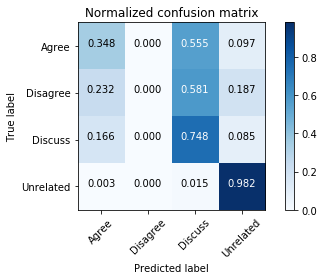

In [154]:
plot_confusion_matrix(matrix, classes=["Agree","Disagree", "Discuss", "Unrelated"],
                      title='Normalized confusion matrix')
plt.show()